# Tutorial 4: Aprendizaje reforzado basado en modelos

---

# Objetivos del Tutorial

En este tutorial modelaremos un agente aún más complejo que aprende a predecir no sólo las recompensas, sino también cómo sus acciones afectan los estados futuros del mundo. Esta información adicional permite al agente utilizar "planificación" para seleccionar sus acciones.

Implementarás uno de los algoritmos de aprendizaje por refuerzo basado en modelos más simples, Dyna-Q. Comprenderán qué es un modelo de mundo, cómo puede mejorar la estrategía del agente y las situaciones en las que los algoritmos basados en modelos son más ventajosos que sus homólogos sin modelos.

* Implementarán un agente RL basado en modelos, Dyna-Q, que puede resolver una tarea sencilla;
* Investigarán el efecto de la planificación en el comportamiento del agente;
* Compararán los comportamientos de un agente basado en modelos y sin modelos ante un cambio ambiental.

---
# Preparación


In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve as conv

In [2]:
# @title Configuraciones de Figura
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [3]:
#@title Funciones de Graficar

def plot_state_action_values(env, value, ax=None):
  """
  Generate plot showing value of each action at each state.
  """
  if ax is None:
    fig, ax = plt.subplots()

  for a in range(env.n_actions):
    ax.plot(range(env.n_states), value[:, a], marker='o', linestyle='--')
  ax.set(xlabel='States', ylabel='Values')
  ax.legend(['R','U','L','D'], loc='lower right')


def plot_quiver_max_action(env, value, ax=None):
  """
  Generate plot showing action of maximum value or maximum probability at
    each state (not for n-armed bandit or cheese_world).
  """
  if ax is None:
    fig, ax = plt.subplots()

  X = np.tile(np.arange(env.dim_x), [env.dim_y,1]) + 0.5
  Y = np.tile(np.arange(env.dim_y)[::-1][:,np.newaxis], [1,env.dim_x]) + 0.5
  which_max = np.reshape(value.argmax(axis=1), (env.dim_y,env.dim_x))
  which_max = which_max[::-1,:]
  U = np.zeros(X.shape)
  V = np.zeros(X.shape)
  U[which_max == 0] = 1
  V[which_max == 1] = 1
  U[which_max == 2] = -1
  V[which_max == 3] = -1

  ax.quiver(X, Y, U, V)
  ax.set(
      title='Maximum value/probability actions',
      xlim=[-0.5, env.dim_x+0.5],
      ylim=[-0.5, env.dim_y+0.5],
  )
  ax.set_xticks(np.linspace(0.5, env.dim_x-0.5, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_xticks(np.arange(env.dim_x+1), minor=True)
  ax.set_yticks(np.linspace(0.5, env.dim_y-0.5, num=env.dim_y))
  ax.set_yticklabels(["%d" % y for y in np.arange(0, env.dim_y*env.dim_x, env.dim_x)])
  ax.set_yticks(np.arange(env.dim_y+1), minor=True)
  ax.grid(which='minor',linestyle='-')


def plot_heatmap_max_val(env, value, ax=None):
  """
  Generate heatmap showing maximum value at each state
  """
  if ax is None:
    fig, ax = plt.subplots()

  if value.ndim == 1:
      value_max = np.reshape(value, (env.dim_y,env.dim_x))
  else:
      value_max = np.reshape(value.max(axis=1), (env.dim_y,env.dim_x))
  value_max = value_max[::-1,:]

  im = ax.imshow(value_max, aspect='auto', interpolation='none', cmap='afmhot')
  ax.set(title='Maximum value per state')
  ax.set_xticks(np.linspace(0, env.dim_x-1, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_yticks(np.linspace(0, env.dim_y-1, num=env.dim_y))
  if env.name != 'windy_cliff_grid':
      ax.set_yticklabels(
          ["%d" % y for y in np.arange(
              0, env.dim_y*env.dim_x, env.dim_x)][::-1])
  return im


def plot_rewards(n_episodes, rewards, average_range=10, ax=None):
  """
  Generate plot showing total reward accumulated in each episode.
  """
  if ax is None:
    fig, ax = plt.subplots()

  smoothed_rewards = (conv(rewards, np.ones(average_range), mode='same')
                      / average_range)

  ax.plot(range(0, n_episodes, average_range),
          smoothed_rewards[0:n_episodes:average_range],
          marker='o', linestyle='--')
  ax.set(xlabel='Episodes', ylabel='Total reward')


def plot_performance(env, value, reward_sums):
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
  plot_state_action_values(env, value, ax=axes[0,0])
  plot_quiver_max_action(env, value, ax=axes[0,1])
  plot_rewards(n_episodes, reward_sums, ax=axes[1,0])
  im = plot_heatmap_max_val(env, value, ax=axes[1,1])
  fig.colorbar(im)

In [4]:
#@title Funciones de Ayuda
def epsilon_greedy(q, epsilon):
  """Epsilon-greedy policy: selects the maximum value action with probabilty
  (1-epsilon) and selects randomly with epsilon probability.

  Args:
    q (ndarray): an array of action values
    epsilon (float): probability of selecting an action randomly

  Returns:
    int: the chosen action
  """
  be_greedy = np.random.random() > epsilon
  if be_greedy:
    action = np.argmax(q)
  else:
    action = np.random.choice(len(q))

  return action


def q_learning(state, action, reward, next_state, value, params):
  """Q-learning: updates the value function and returns it.

  Args:
    state (int): the current state identifier
    action (int): the action taken
    reward (float): the reward received
    next_state (int): the transitioned to state identifier
    value (ndarray): current value function of shape (n_states, n_actions)
    params (dict): a dictionary containing the default parameters

  Returns:
    ndarray: the updated value function of shape (n_states, n_actions)
  """
  # value of previous state-action pair
  prev_value = value[int(state), int(action)]

  # maximum Q-value at current state
  if next_state is None or np.isnan(next_state):
      max_value = 0
  else:
      max_value = np.max(value[int(next_state)])

  # reward prediction error
  delta = reward + params['gamma'] * max_value - prev_value

  # update value of previous state-action pair
  value[int(state), int(action)] = prev_value + params['alpha'] * delta

  return value


def learn_environment(env, model_updater, planner, params, max_steps,
                      n_episodes, shortcut_episode=None):
  # Start with a uniform value function
  value = np.ones((env.n_states, env.n_actions))

  # Run learning
  reward_sums = np.zeros(n_episodes)
  episode_steps = np.zeros(n_episodes)

  # Dyna-Q state
  model = np.nan*np.zeros((env.n_states, env.n_actions, 2))

  # Loop over episodes
  for episode in range(n_episodes):
    if shortcut_episode is not None and episode == shortcut_episode:
      env.toggle_shortcut()
      state = 64
      action = 1
      next_state, reward = env.get_outcome(state, action)
      model[state, action] = reward, next_state
      value = q_learning(state, action, reward, next_state, value, params)


    state = env.init_state  # initialize state
    reward_sum = 0

    for t in range(max_steps):
      # choose next action
      action = epsilon_greedy(value[state], params['epsilon'])

      # observe outcome of action on environment
      next_state, reward = env.get_outcome(state, action)

      # sum rewards obtained
      reward_sum += reward

      # update value function
      value = q_learning(state, action, reward, next_state, value, params)

      # update model
      model = model_updater(model, state, action, reward, next_state)

      # execute planner
      value = planner(model, value, params)

      if next_state is None:
        break  # episode ends
      state = next_state

    reward_sums[episode] = reward_sum
    episode_steps[episode] = t+1

  return value, reward_sums, episode_steps


class world(object):
    def __init__(self):
        return

    def get_outcome(self):
        print("Abstract method, not implemented")
        return

    def get_all_outcomes(self):
        outcomes = {}
        for state in range(self.n_states):
            for action in range(self.n_actions):
                next_state, reward = self.get_outcome(state, action)
                outcomes[state, action] = [(1, next_state, reward)]
        return outcomes

class QuentinsWorld(world):
    """
    World: Quentin's world.
    100 states (10-by-10 grid world).
    The mapping from state to the grid is as follows:
    90 ...       99
    ...
    40 ...       49
    30 ...       39
    20 21 22 ... 29
    10 11 12 ... 19
    0  1  2  ...  9
    54 is the start state.
    Actions 0, 1, 2, 3 correspond to right, up, left, down.
    Moving anywhere from state 99 (goal state) will end the session.
    Landing in red states incurs a reward of -1.
    Landing in the goal state (99) gets a reward of 1.
    Going towards the border when already at the border will stay in the same
        place.
    """
    def __init__(self):
        self.name = "QuentinsWorld"
        self.n_states = 100
        self.n_actions = 4
        self.dim_x = 10
        self.dim_y = 10
        self.init_state = 54
        self.shortcut_state = 64

    def toggle_shortcut(self):
      if self.shortcut_state == 64:
        self.shortcut_state = 2
      else:
        self.shortcut_state = 64

    def get_outcome(self, state, action):
        if state == 99:  # goal state
            reward = 0
            next_state = None
            return next_state, reward
        reward = 0  # default reward value
        if action == 0:  # move right
            next_state = state + 1
            if state == 98:  # next state is goal state
                reward = 1
            elif state % 10 == 9:  # right border
                next_state = state
            elif state in [11, 21, 31, 41, 51, 61, 71,
                           12, 72,
                           73,
                           14, 74,
                           15, 25, 35, 45, 55, 65, 75]:  # next state is red
                reward = -1
        elif action == 1:  # move up
            next_state = state + 10
            if state == 89:  # next state is goal state
                reward = 1
            if state >= 90:  # top border
                next_state = state
            elif state in [2, 12, 22, 32, 42, 52, 62,
                           3, 63,
                           self.shortcut_state,
                           5, 65,
                           6, 16, 26, 36, 46, 56, 66]:  # next state is red
                reward = -1
        elif action == 2:  # move left
            next_state = state - 1
            if state % 10 == 0:  # left border
                next_state = state
            elif state in [17, 27, 37, 47, 57, 67, 77,
                           16, 76,
                           75,
                           14, 74,
                           13, 23, 33, 43, 53, 63, 73]:  # next state is red
                reward = -1
        elif action == 3:  # move down
            next_state = state - 10
            if state <= 9:  # bottom border
                next_state = state
            elif state in [22, 32, 42, 52, 62, 72, 82,
                           23, 83,
                           84,
                           25, 85,
                           26, 36, 46, 56, 66, 76, 86]:  # next state is red
                reward = -1
        else:
            print("Action must be between 0 and 3.")
            next_state = None
            reward = None
        return int(next_state) if next_state is not None else None, reward

---

# Sección 1: RL Basado en modelos

Los algoritmos introducidos en los tutoriales anteriores son todos *libres de modelos*, ya que no requieren un modelo para usar o controlar el comportamiento. En esta sección, estudiaremos una clase diferente de algoritmos llamados basados en modelos. Como veremos a continuación, a diferencia de la RL sin modelos, los métodos basados en modelos utilizan un modelo para construir una estrategía.

Pero ¿qué es un modelo? Un modelo (a veces llamado modelo de mundo o modelo interno) es una representación de cómo responderá el mundo a las acciones del agente. Pueden pensar en ello como una representación de cómo *funciona* el mundo. Con tal representación, el agente puede simular nuevas experiencias y aprender de estas simulaciones. Esto es ventajoso por dos razones. En primer lugar, actuar en el mundo real puede resultar costoso y, a veces, incluso peligroso: ¿recuerdan Cliff World del Tutorial 3? Aprender de la experiencia simulada puede evitar algunos de estos costos o riesgos. En segundo lugar, las simulaciones aprovechan al máximo la experiencia limitada de uno. Para ver por qué, imaginemos a un agente interactuando con el mundo real. La información adquirida con cada acción individual sólo puede ser asimilada en el momento de la interacción. Por el contrario, las experiencias simuladas a partir de un modelo se pueden simular varias veces -- y cuando se desee -- lo que permite que la información se asimile más plenamente.


**Ambiente de mundo de Quentin**

En este tutorial el agente va a actuar en el mundo de Quentin, un mundo de cuadrícula 10x10.

<img alt="QuentinsWorld" width="560" height="560" src="https://github.com/NeuromatchAcademy/course-content/blob/main/tutorials/static/W3D4_Tutorial4_QuentinsWorld.png?raw=true">


En este entorno hay 100 estados y 4 acciones posibles: derecha, arriba, izquierda y abajo. El objetivo del agente es moverse, a través de una serie de pasos, desde la ubicación inicial (verde) hasta la región objetivo (amarilla), evitando las paredes rojas. Más específicamente:
* El agente empieza en el estado verde
* Moverse a uno de los estados rojos genera una recompensa de -1
* Moverse hacia las fronteras del mundo te deja en el mismo lugar
* Moverse hacia la meta (el cuadrado amarillo en la esquina superior derecha) genera una recompensa de 1
* Moverse a cualquier lugar desde el estado de meta termina el episodio.

Ahora que tenemos definido nuestro ambiente y tarea, cómo podemos resolver esto utilizando un agente RL basado en modelos?


---
# Sección 2: Dyna-Q

En esta sección, implementaremos Dyna-Q, uno de los algoritmos de aprendizaje por refuerzo basado en modelos más simples. Un agente Dyna-Q combina actuación, aprendizaje y planificación. Los dos primeros componentes -- actuar y aprender -- son exactamente iguales a lo que hemos estudiado anteriormente. El Q-learning, por ejemplo, aprende actuando en el mundo y, por tanto, combina actuación y aprendizaje. Pero un agente Dyna-Q también implementa la planificación o simula experiencias a partir de un modelo y aprende de ellas.


En teoría, se puede pensar que un agente Dyna-Q implementa la acción, el aprendizaje y la planificación simultáneamente, en todo momento. Pero, en la práctica, es necesario especificar el algoritmo como una secuencia de pasos. La forma más común en la que se implementa el agente Dyna-Q es agregando una rutina de planificación a un agente Q-learning: después de que el agente actúa en el mundo real y aprende de la experiencia observada, se le permite una serie de $k$ *pasos de planificación*. En cada uno de esos $k$ pasos de planificación, el modelo genera una experiencia simulada mediante un muestreo aleatorio del historial de todos los pares estado-acción previamente experimentados. Luego, el agente aprende de esta experiencia simulada, utilizando nuevamente la misma regla de Q-learning que implementó para aprender de la experiencia real. Esta experiencia simulada es simplemente una transición de un solo paso, es decir, un estado, una acción y el estado y la recompensa resultantes. Entonces, en la práctica, un agente Dyna-Q aprende (a través de Q-learning) de un paso de experiencia **real** durante la actuación, y luego de k pasos de experiencia **simulada** durante la planificación.

Hay un último detalle sobre este algoritmo: ¿de dónde provienen las experiencias simuladas o, en otras palabras, cuál es el "modelo"? En Dyna-Q, a medida que el agente interactúa con el entorno, el agente también aprende el modelo. Para simplificar, Dyna-Q implementa el aprendizaje de modelos de una manera casi trivial, simplemente almacenando los resultados de cada transición. Así, después de cada transición de un paso en el entorno, el agente guarda los resultados de esta transición en una gran matriz y consulta esa matriz durante cada uno de los pasos de planificación. Obviamente, esta estrategia de aprendizaje de modelos sólo tiene sentido si el mundo es determinista (de modo que cada par estado-acción siempre conduzca al mismo estado y recompensa), y este es el escenario del ejercicio siguiente. Sin embargo, incluso esta simple configuración ya puede resaltar una de las principales fortalezas de Dyna-Q: el hecho de que la planificación se realiza al mismo tiempo que el agente interactúa con el entorno, lo que significa que la nueva información obtenida de la interacción puede cambiar el modelo y interactúan así con la planificación de maneras potencialmente interesantes.


Como ya implementaron Q-learning en el tutorial previo vamos a poder enfocarnos  en las extensiones nuevas a Dyna-Q: la tasa de actualización del modelo y el paso de planificación. Para referencia, acá esta el algoritmo Dyna-Q que van a ayudar a implementar:

---
**DYNA-Q TABULAR**

Inicializa $Q(s,a)$ y $Model(s,a)$ para todo $s \in S$ y $a \in A$.

Repite por siempre:

> (a) $S$ &larr; estado actual (no terminal) <br>
> (b) $A$ &larr; $\epsilon$-codicioso$(S,Q)$ <br>
> (c) Tomar acción $A$; observar recompensa resultante, $R$, y estado, $S'$ <br>
> (d) $Q(S,A)$ &larr; $Q(S,A) + \alpha \left[R + \gamma \max_{a} Q(S',a) - Q(S,A)\right]$ <br>
> (e) $Model(S,A)$ &larr; $R,S'$ (asumiendo ambiente determinista) <br>
> (f) Repetir $k$ veces: <br>
>> $S$ &larr; estado aleatorio visto anteriormente <br>
>> $A$ &larr; acción aleatoria previamente tomada en $S$ <br>
>> $R,S'$ &larr; $Model(S,A)$ <br>
>> $Q(S,A)$ &larr; $Q(S,A) + \alpha \left[R + \gamma \max_{a} Q(S',a) - Q(S,A)\right]$ <br>


---

## Ejercicio de programación 2.1: Actualización en el modelo Dyna-Q

En este ejercicio, implementará la parte de actualización del modelo del algoritmo Dyna-Q. Más específicamente, después de cada acción que el agente ejecuta en el mundo, debemos actualizar nuestro modelo para recordar qué recompensa y siguiente estado experimentamos por última vez para el par estado-acción dado.

In [5]:

def dyna_q_model_update(model, state, action, reward, next_state):
  """ Dyna-Q model update

  Args:
    model (ndarray): An array of shape (n_states, n_actions, 2) that represents
                     the model of the world i.e. what reward and next state do
                     we expect from taking an action in a state.
    state (int): the current state identifier
    action (int): the action taken
    reward (float): the reward received
    next_state (int): the transitioned to state identifier

  Returns:
    ndarray: the updated model
  """
  # Update our model with the observed reward and next state
  model[state, action] = reward, next_state

  return model

Ahora que tenemos una forma de actualizar nuestro modelo, podemos usarlo en la fase de planificación de Dyna-Q para simular experiencias pasadas.

## Ejercicio de programación 2.2: Planificación en Dyna-Q

En este ejercicio implementará la otra parte clave de Dyna-Q: la planificación. Tomaremos muestras de un par aleatorio de estado-acción de aquellos que hemos experimentado, usaremos nuestro modelo para simular la experiencia de realizar esa acción en ese estado y actualizaremos nuestra función de valor usando Q-learning con estos estados, acciones, recompensas, y próximos estados. Además, queremos ejecutar este paso de planificación $k$ veces, que se puede obtener de `params['k']`.

Para este ejercicio, puede utilizar la función `q_learning` para manejar la actualización de la función de valor de Q-learning. Recuerde que la entrada del método es `q_learning(state, action, reward, next_state, value, params)` y devuelve la tabla de `values` actualizada.

Después de completar esta función, tenemos una manera de actualizar nuestro modelo y una manera de usarlo en la planificación para verlo en acción. El código configura los parámetros de nuestro agente y el entorno de aprendizaje, luego pasa la actualización del modelo y los métodos de planificación al agente para intentar resolver el mundo de Quentin. Observe que establecemos el número de pasos de planificación $k=10$.

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


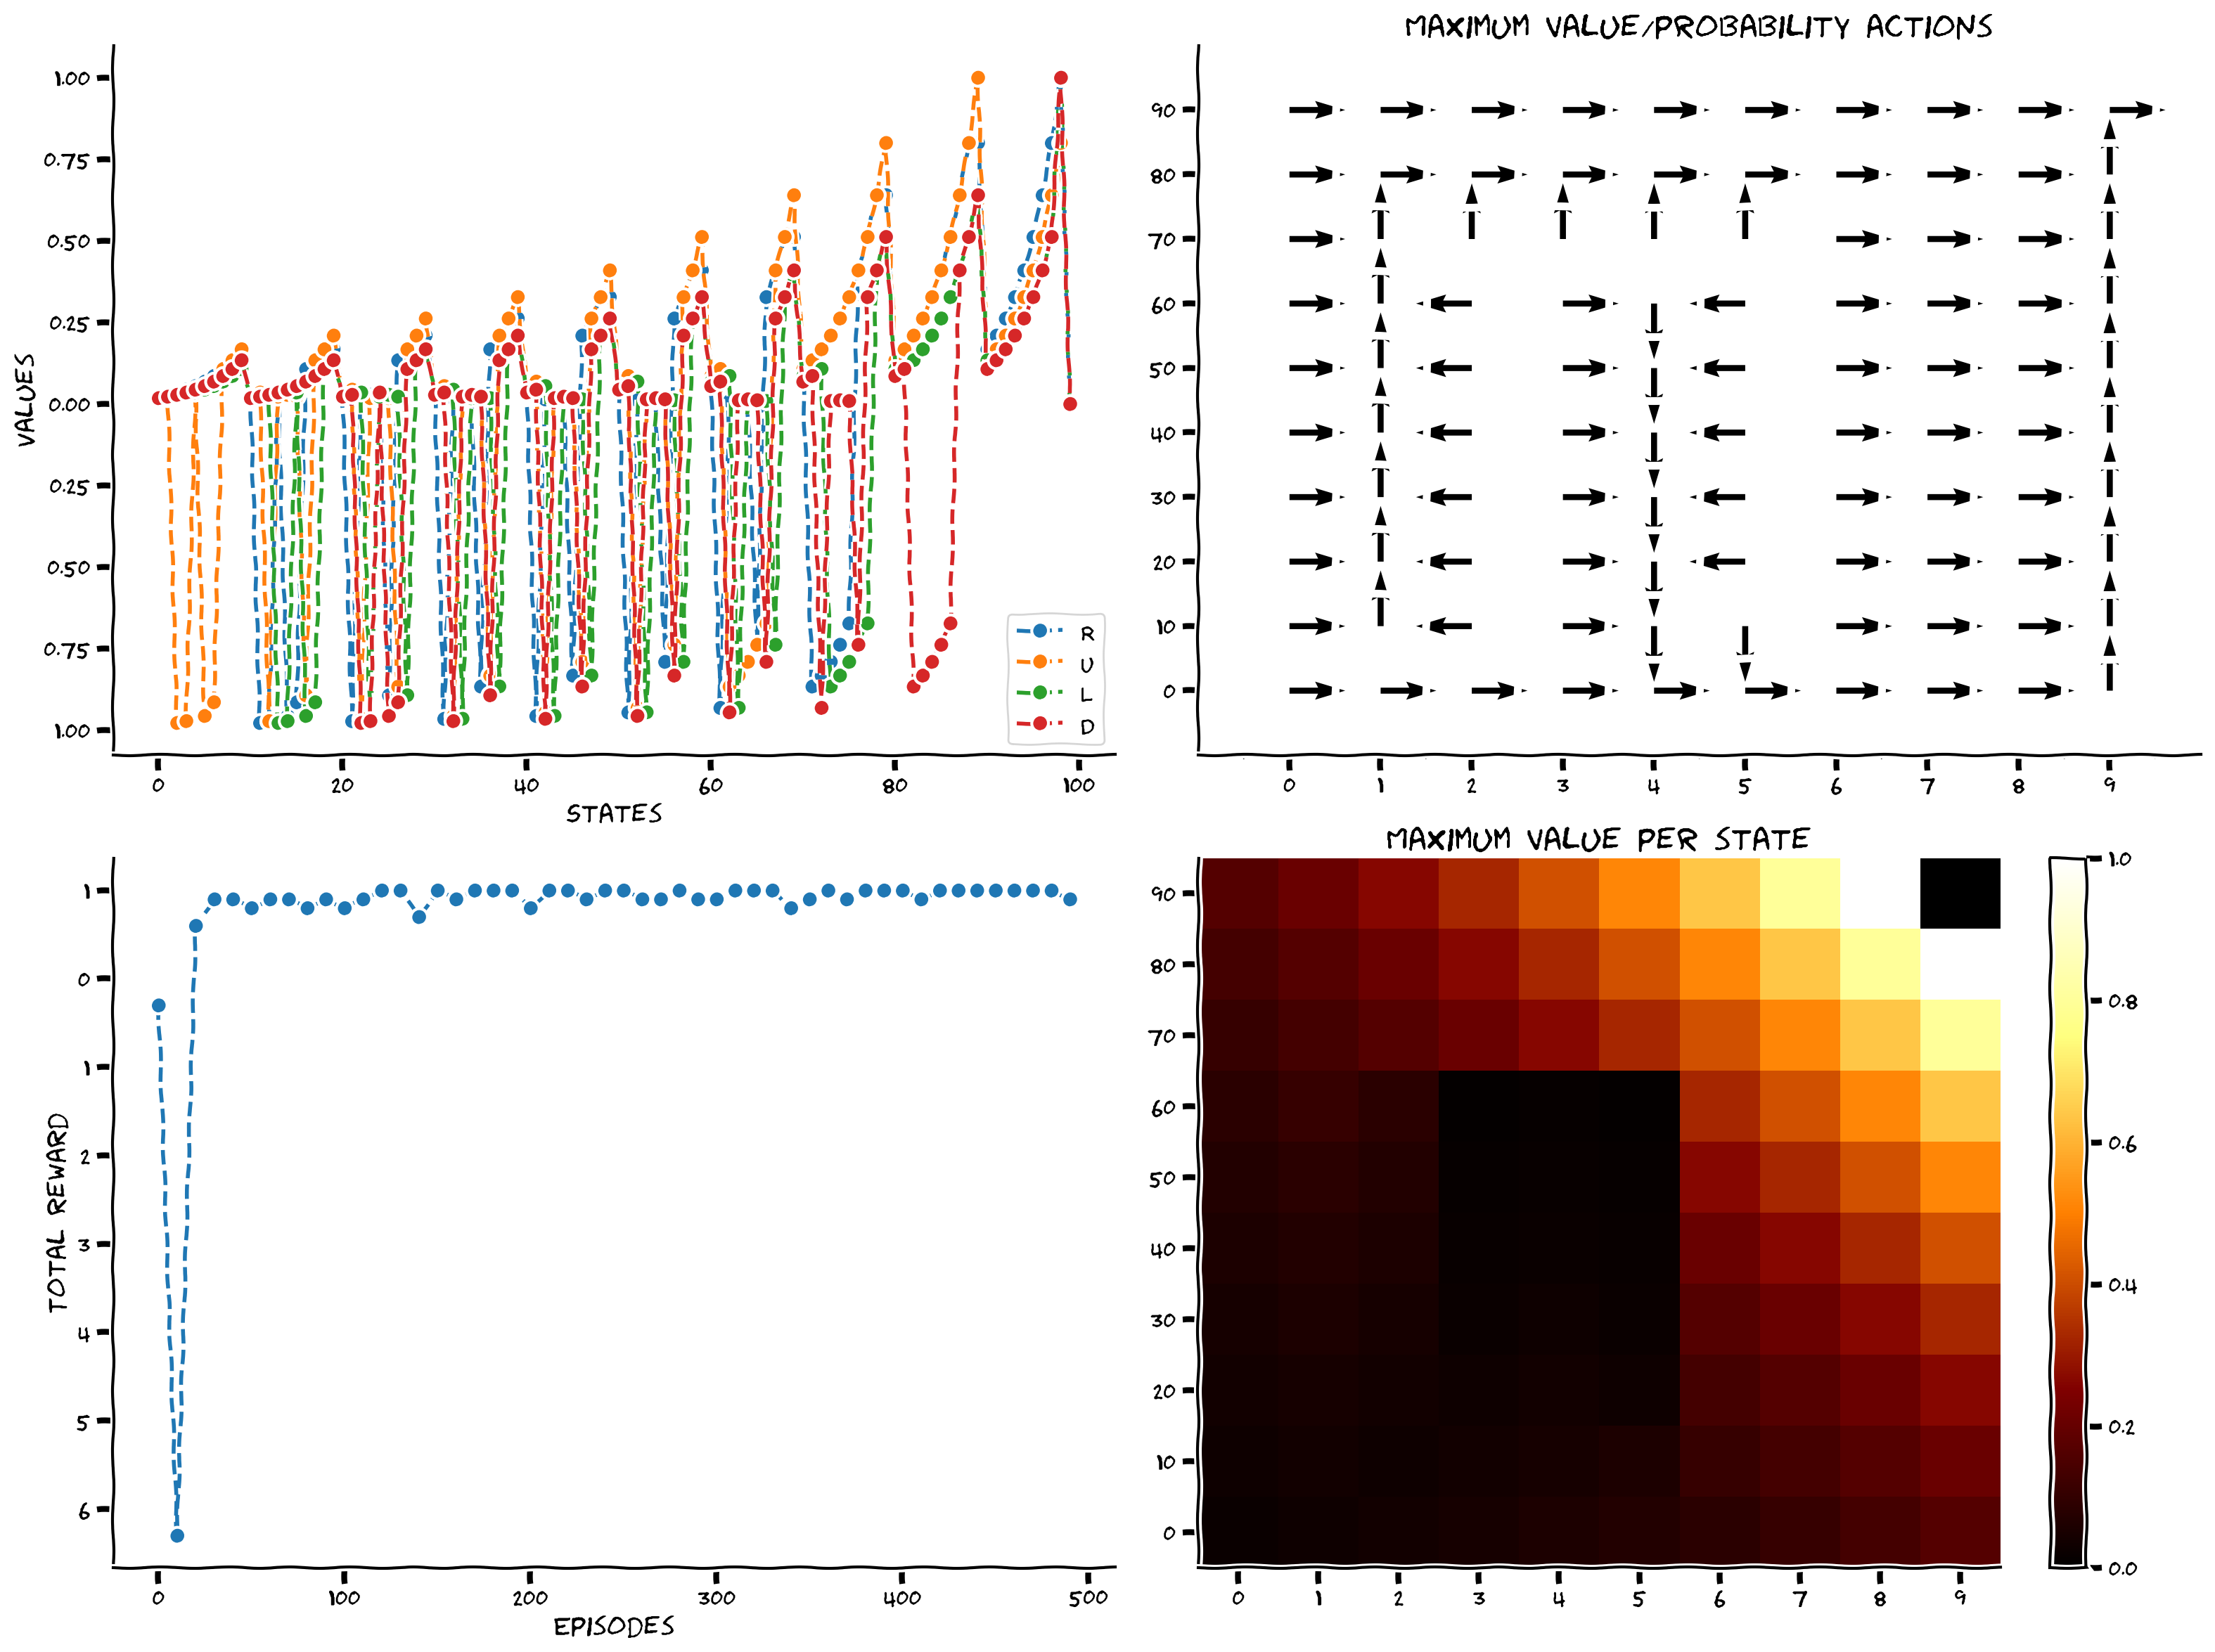

In [6]:

def dyna_q_planning(model, value, params):
  """ Dyna-Q planning

  Args:
    model (ndarray): An array of shape (n_states, n_actions, 2) that represents
                     the model of the world i.e. what reward and next state do
                     we expect from taking an action in a state.
    value (ndarray): current value function of shape (n_states, n_actions)
    params (dict): a dictionary containing learning parameters

  Returns:
    ndarray: the updated value function of shape (n_states, n_actions)
  """
  # Perform k additional updates at random (planning)
  for _ in range(params['k']):
    # Find state-action combinations for which we've experienced a reward i.e.
    # the reward value is not NaN. The outcome of this expression is an Nx2
    # matrix, where each row is a state and action value, respectively.
    candidates = np.array(np.where(~np.isnan(model[:,:,0]))).T

    # Write an expression for selecting a random row index from our candidates
    idx = np.random.choice(len(candidates))

    # Obtain the randomly selected state and action values from the candidates
    state, action = candidates[idx]

    # Obtain the expected reward and next state from the model
    reward, next_state = model[state, action]

    # Update the value function using Q-learning
    value = q_learning(state, action, reward, next_state, value, params)

  return value


# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.05,  # epsilon-greedy policy
  'alpha': 0.5,  # learning rate
  'gamma': 0.8,  # temporal discount factor
  'k': 10,  # number of Dyna-Q planning steps
}

# episodes/trials
n_episodes = 500
max_steps = 1000

# environment initialization
env = QuentinsWorld()

# solve Quentin's World using Dyna-Q
results = learn_environment(env, dyna_q_model_update, dyna_q_planning,
                            params, max_steps, n_episodes)
value, reward_sums, episode_steps = results

# Plot the results
with plt.xkcd():
  plot_performance(env, value, reward_sums)

Al finalizar, deberíamos ver que nuestro agente Dyna-Q es capaz de resolver la tarea con bastante rapidez, logrando una recompensa positiva constante después de solo un número limitado de episodios (abajo a la izquierda).

---
# Sección 3: ¿Cuánto planificar?


Ahora que implementó un agente Dyna-Q con $k=10$, intentaremos comprender el efecto de la planificación en el rendimiento. ¿Cómo afecta el cambio del valor de $k$ la capacidad de aprendizaje de nuestro agente?

El siguiente código es similar al que acabamos de ejecutar, solo que esta vez ejecutamos varios experimentos con varios valores diferentes de $k$ para ver cómo se compara su rendimiento promedio. En particular, elegiremos $k \in \{0, 1, 10, 100\}$. Preste especial atención al caso donde $k = 0$ que corresponde a no planificar. Esto es, en efecto, simplemente Q-learning normal.

El siguiente código tardará un poco en completarse. Para acelerar las cosas, intente reducir la cantidad de experimentos o la cantidad de valores $k$ para comparar.

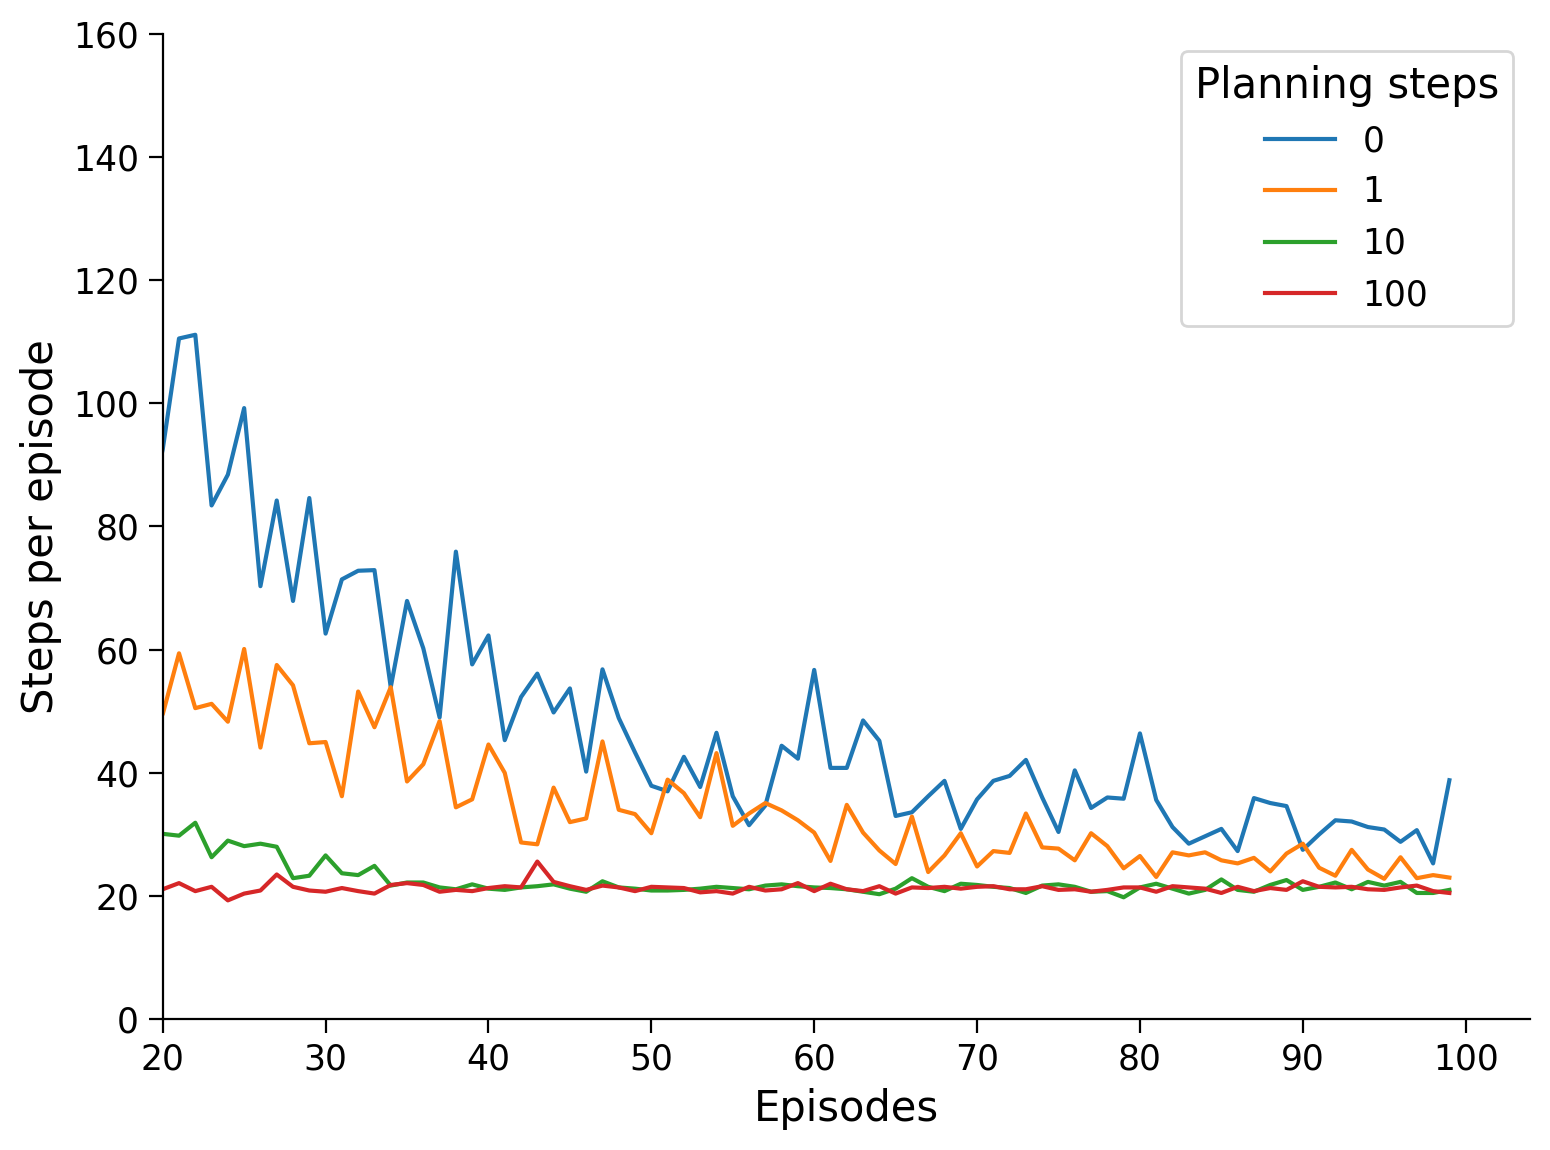

In [7]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.05,  # epsilon-greedy policy
  'alpha': 0.5,  # learning rate
  'gamma': 0.8,  # temporal discount factor
}

# episodes/trials
n_experiments = 10
n_episodes = 100
max_steps = 1000

# number of planning steps
planning_steps = np.array([0, 1, 10, 100])

# environment initialization
env = QuentinsWorld()

steps_per_episode = np.zeros((len(planning_steps), n_experiments, n_episodes))

for i, k in enumerate(planning_steps):
  params['k'] = k
  for experiment in range(n_experiments):
    results = learn_environment(env, dyna_q_model_update, dyna_q_planning,
                                params, max_steps, n_episodes)
    steps_per_episode[i, experiment] = results[2]

# Average across experiments
steps_per_episode = np.mean(steps_per_episode, axis=1)

# Plot results
fig, ax = plt.subplots()
ax.plot(steps_per_episode.T)
ax.set(xlabel='Episodes', ylabel='Steps per episode',
       xlim=[20, None], ylim=[0, 160])
ax.legend(planning_steps, loc='upper right', title="Planning steps");

Después de una fase de calentamiento inicial de 20 episodios, deberíamos ver que la cantidad de pasos de planificación tiene un impacto notable en la capacidad de nuestro agente para resolver rápidamente el entorno. También debemos notar que después de un cierto valor de $k$ nuestra utilidad relativa disminuye, por lo que es importante equilibrar un valor de $k$ lo suficientemente grande que nos ayude a aprender rápidamente sin perder demasiado tiempo en la planificación.

---
# Sección 4: Cuando el mundo cambia...

Además de acelerar el aprendizaje sobre un nuevo entorno, la planificación también puede ayudar al agente a incorporar rápidamente nueva información sobre el entorno a su política. Por lo tanto, si el entorno cambia (por ejemplo, las reglas que gobiernan las transiciones entre estados, o las recompensas asociadas con cada estado/acción), el agente no necesita experimentar ese cambio *repetidamente* (como sería requerido en un Q-learning). agente) en experiencia real. En cambio, la planificación permite incorporar ese cambio rápidamente a la política del agente, sin necesidad de experimentar el cambio más de una vez.

En esta sección final, nuevamente nuestros agentes intentarán resolver el mundo de Quentin. Sin embargo, después de 200 episodios, aparecerá un atajo en el entorno. Probaremos cómo un agente libre de modelos que utiliza Q-learning y un agente Dyna-Q se adaptan a este cambio en el entorno.

<img alt="QuentinsWorldShortcut" width="560" height="560" src="https://github.com/NeuromatchAcademy/course-content/blob/main/tutorials/static/W3D4_Tutorial4_QuentinsWorldShortcut.png?raw=true">



El siguiente código nuevamente es similar al que ejecutamos anteriormente. Al igual que arriba, tendremos múltiples valores para $k$, donde $k=0$ representa nuestro agente Q-learning y $k=10$ para nuestro agente Dyna-Q con 10 pasos de planificación. La principal diferencia es que ahora agregamos un indicador de cuándo aparece el atajo. En particular, ejecutaremos los agentes durante 400 episodios, y el atajo aparecerá en el medio después del episodio 200.

Cuando aparezca este atajo, también dejaremos que cada agente experimente este cambio una vez, es decir, evaluaremos el acto de moverse hacia arriba cuando esté en el estado que está debajo del atajo ahora abierto. Tras esta única demostración, los agentes seguirán interactuando en el entorno.

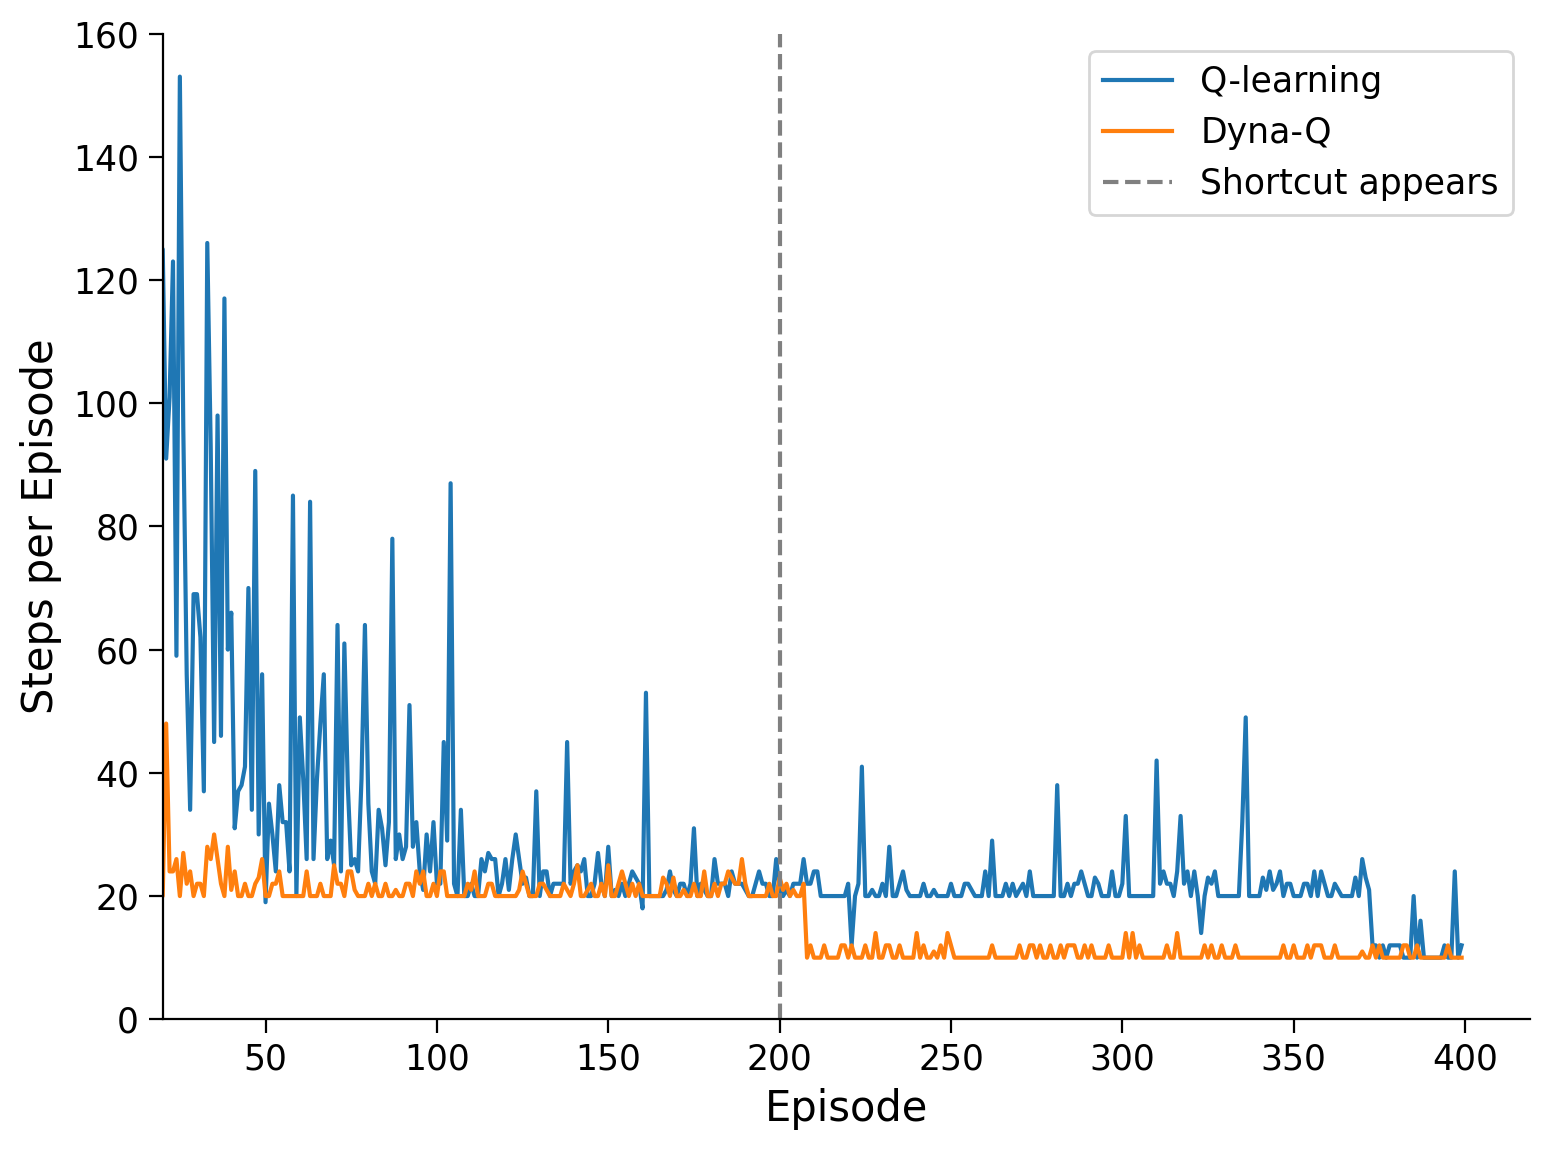

In [8]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.05,  # epsilon-greedy policy
  'alpha': 0.5,  # learning rate
  'gamma': 0.8,  # temporal discount factor
}

# episodes/trials
n_episodes = 400
max_steps = 1000
shortcut_episode = 200  # when we introduce the shortcut

# number of planning steps
planning_steps = np.array([0, 10]) # Q-learning, Dyna-Q (k=10)

# environment initialization
steps_per_episode = np.zeros((len(planning_steps), n_episodes))

# Solve Quentin's World using Q-learning and Dyna-Q
for i, k in enumerate(planning_steps):
  env = QuentinsWorld()
  params['k'] = k
  results = learn_environment(env, dyna_q_model_update, dyna_q_planning,
                              params, max_steps, n_episodes,
                              shortcut_episode=shortcut_episode)
  steps_per_episode[i] = results[2]


# Plot results
fig, ax = plt.subplots()
ax.plot(steps_per_episode.T)
ax.set(xlabel='Episode', ylabel='Steps per Episode',
       xlim=[20,None], ylim=[0, 160])
ax.axvline(shortcut_episode, linestyle="--", color='gray', label="Shortcut appears")
ax.legend(('Q-learning', 'Dyna-Q', 'Shortcut appears'),
          loc='upper right');

Si todo salió bien, deberíamos ver que el agente Dyna-Q ya logró un rendimiento casi óptimo antes de la aparición del atajo y luego incorporó inmediatamente esta nueva información para mejorar aún más. En este caso, el agente Q-learning tarda mucho más en incorporar completamente el nuevo atajo.

---
# Resumen

En este notebook, aprendió sobre el aprendizaje por refuerzo basado en modelos e implementó una de las arquitecturas más simples de este tipo, Dyna-Q. Dyna-Q es muy parecido a Q-learning, pero en lugar de aprender sólo de la experiencia real, también aprendes de la experiencia **simulada**. ¡Esta pequeña diferencia, sin embargo, puede tener enormes beneficios! La planificación *libera* al agente de la limitación de su propio entorno, y esto a su vez le permite acelerar el aprendizaje (por ejemplo, incorporando eficazmente los cambios ambientales en su política).

No es sorprendente que la RL basada en modelos sea un área activa de investigación en el aprendizaje automático. Algunos de los temas interesantes en la frontera de este campo implican (i) aprender y representar un modelo complejo del mundo (es decir, más allá del caso tabular y determinista anterior) y (ii) qué simular, también conocido como control de búsqueda (_search control_). (es decir, más allá de la selección aleatoria de experiencias implementada anteriormente).

El marco anterior también se ha utilizado en neurociencia para explicar diversos fenómenos como la planificación, el muestreo de la memoria, la consolidación de la memoria e incluso los sueños.